In [1]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, AncillaRegister
from qiskit import Aer
from qiskit.opflow import X, Z, I, MatrixEvolution
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.circuit import Parameter
from qiskit import transpile
from scipy import linalg
from scipy.special import binom
import matplotlib.pyplot as plt
from qutip import *
import itertools as it
import copy
import stomp_functions as stf
from qiskit.quantum_info import random_clifford
import time
from qiskit.providers.fake_provider import FakeBelem

/tmp/ipykernel_25965/3572349411.py:4: DeprecationWarning: The ``qiskit.opflow`` module is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  from qiskit.opflow import X, Z, I, MatrixEvolution


In [2]:
def create_H(N, g, j):
    z_ops, x_ops = stf.construct_op_lists(N)
    
    # Construct the Hamiltonian
    # Loop over sites to construct parts of H
    H_qis = 0
    for n in range(N-1):
        H_qis += -j * z_ops[n] @ z_ops[n+1]
        for m in range(N):
            H_qis += -j * g * x_ops[n]

    return H_qis

In [3]:
def trotter_H(N, g, j):
    z_ops, x_ops = stf.construct_op_lists(N)
    
    H_z, H_x = 0, 0
    for n in range(N-1):
        H_z += -j * z_ops[n] @ z_ops[n+1]
        for m in range(N):
            H_x += -j * g * x_ops[n]
            
    return H_z, H_x

In [4]:
def create_wf(N, seed):
    init_wf = np.zeros(N ** 2)
    init_wf[0] = 1
    cliff = random_clifford(N, seed)
    return cliff

In [5]:
# Set font size of plot elements
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [6]:
backend = Aer.get_backend('aer_simulator')
#backend = 
num_shots = 1*8192

# Set up parameters for unitary
beta = 0.2
num_steps = 10
betas, dt = np.linspace(0, beta, num_steps, retstep=True)

In [7]:
g, j = 2, 1
seed = 1
qar = AncillaRegister(1)
cr = ClassicalRegister(1)

he_circs_re = []
he_circs_im = []
H_circs_re = []
H_circs_im = []

Uf_circs = []
for n in range(2, 7):
    # Create hamiltonian
    H = create_H(n, g, j)
    
    # Create initial wf clifford
    cliff = create_wf(n, seed)
    
    # Create circuit register
    qr = QuantumRegister(n)
    control_args = [q for q in qr]
    control_args.insert(0, qar)
    
    # Get circuits for real and imaginary Hadamard estimation with no observable
    he_circs_re.append(stf.had_est_barr(qr, qar, cr, H, None, 2, 
                                      dt, cliff))
    he_circs_im.append(stf.im_had_est_barr(qr, qar, cr, H, None, 2, 
                                      dt, cliff))
    
    # Now perform hadmard estimation on each string
    """
    H_r = {}
    H_i = {}
    for key in pauli_H:
        if abs(pauli_H[key]) != 0:
            H_r[key] = stf.had_est_barr(qr, qar, cr, H, Pauli(key), 2, dt,
                                                 cliff)
        
            H_i[key] = stf.im_had_est_barr(qr, qar, cr, H, Pauli(key), 2,
                                                                   dt, cliff)
            
    H_circs_re.append(H_r)
    H_circs_im.append(H_i)
    """

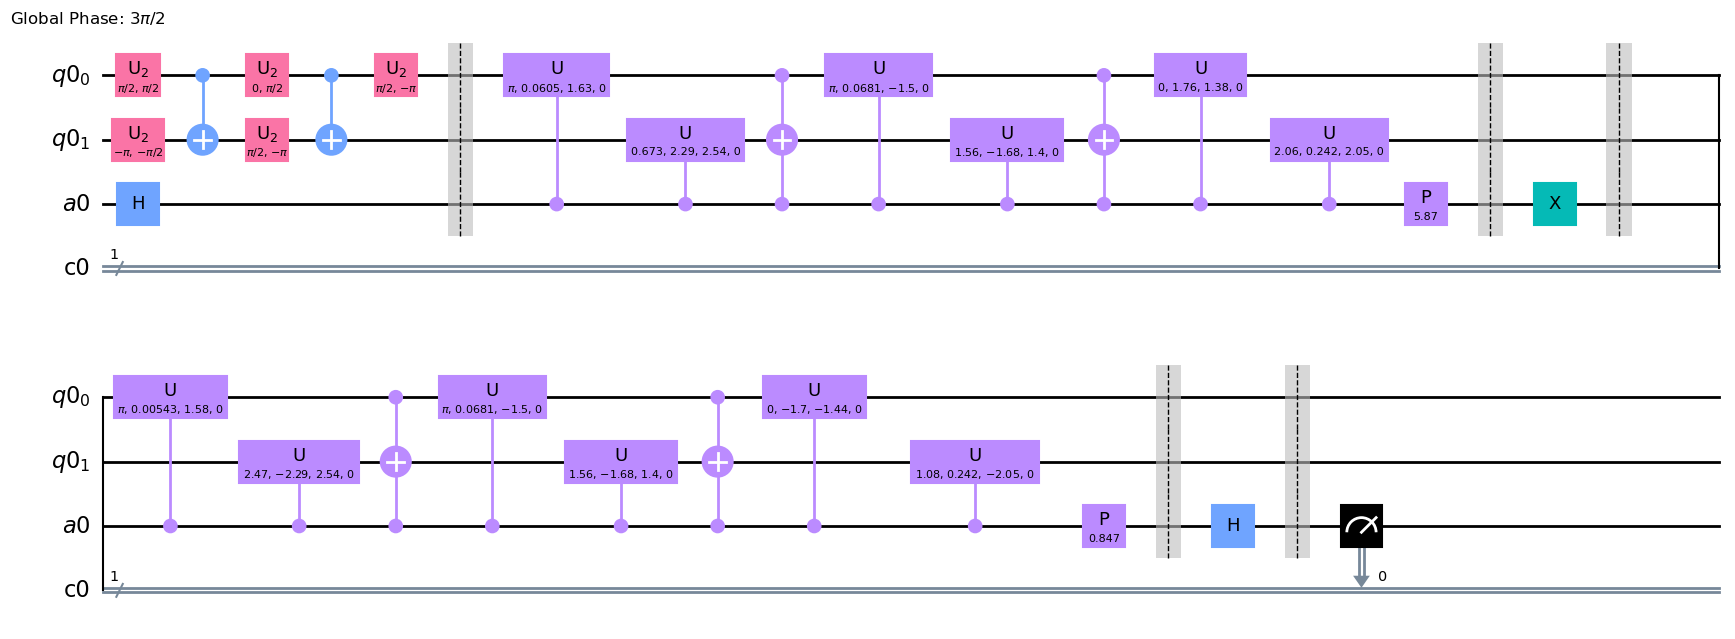

In [8]:
transpile(he_circs_re[0], backend)[-1].draw('mpl')

In [9]:
re_depths = []
im_depths = []
for _ in zip(he_circs_re, he_circs_im):
    re_init_depth = transpile(_[0], backend)[0].depth()
    im_init_depth = transpile(_[0], backend)[0].depth()
    
    re_depths.append(transpile(_[0], backend)[-1].depth() - re_init_depth)
    im_depths.append(transpile(_[1], backend)[-1].depth() - im_init_depth)

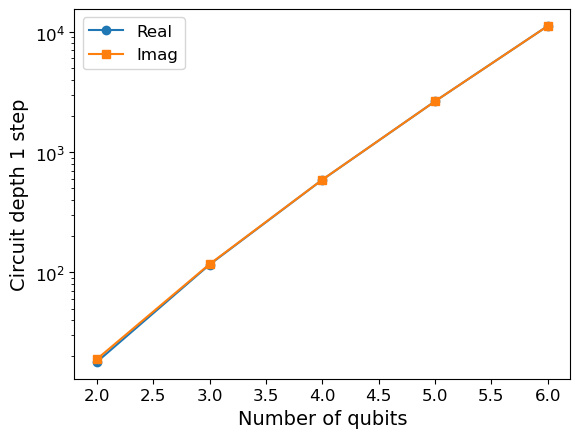

In [10]:
plt.semilogy(np.arange(2, 7), re_depths, 'o-', label='Real')
plt.semilogy(np.arange(2, 7), im_depths, 's-', label='Imag')
plt.xlabel("Number of qubits")
plt.ylabel("Circuit depth 1 step")
plt.legend()
plt.savefig("depth_vs_qubits_aersim.png", format='png', dpi=300)

In [11]:
# Now compare to the case where we have explicit trotterization
trot_circs_re = []
trot_circs_im = []

g, j = 2, 1
seed = 1
qar = AncillaRegister(1)
cr = ClassicalRegister(1)

for n in range(2, 7):
    # Create hamiltonian
    H = create_H(n, g, j)
    
    # Create initial wf clifford
    cliff = create_wf(n, seed)
    
    # Create circuit register
    qr = QuantumRegister(n)
    control_args = [q for q in qr]
    control_args.insert(0, qar)
    
    # Get circuits for real and imaginary Hadamard estimation with no observable
    trot_circs_re.append(stf.had_est_barr_trot(qr, qar, cr, H, None, 2, 
                                      dt, cliff))
    trot_circs_im.append(stf.imag_had_est_barr_trot(qr, qar, cr, H, None, 2, 
                                      dt, cliff))

In [12]:
re_trot_depths = []
im_trot_depths = []
for _ in zip(trot_circs_re, trot_circs_im):
    re_init_depth = transpile(_[0], backend)[0].depth()
    im_init_depth = transpile(_[1], backend)[0].depth()
    
    re_trot_depths.append(transpile(_[0], backend)[-1].depth() - re_init_depth)
    im_trot_depths.append(transpile(_[1], backend)[-1].depth() - im_init_depth)

Text(0, 0.5, 'Circuit depth')

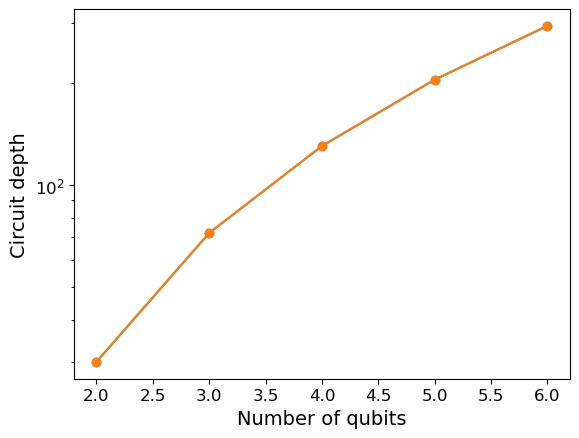

In [17]:
plt.semilogy(np.arange(2, 7), re_trot_depths, 'o-', label='Real')
plt.semilogy(np.arange(2, 7), im_trot_depths, 'o-', label='Imag')
plt.xlabel("Number of qubits")
plt.ylabel("Circuit depth")

In [14]:
trot_tcs = [transpile(_, backend)[-1] for _ in trot_circs_re]

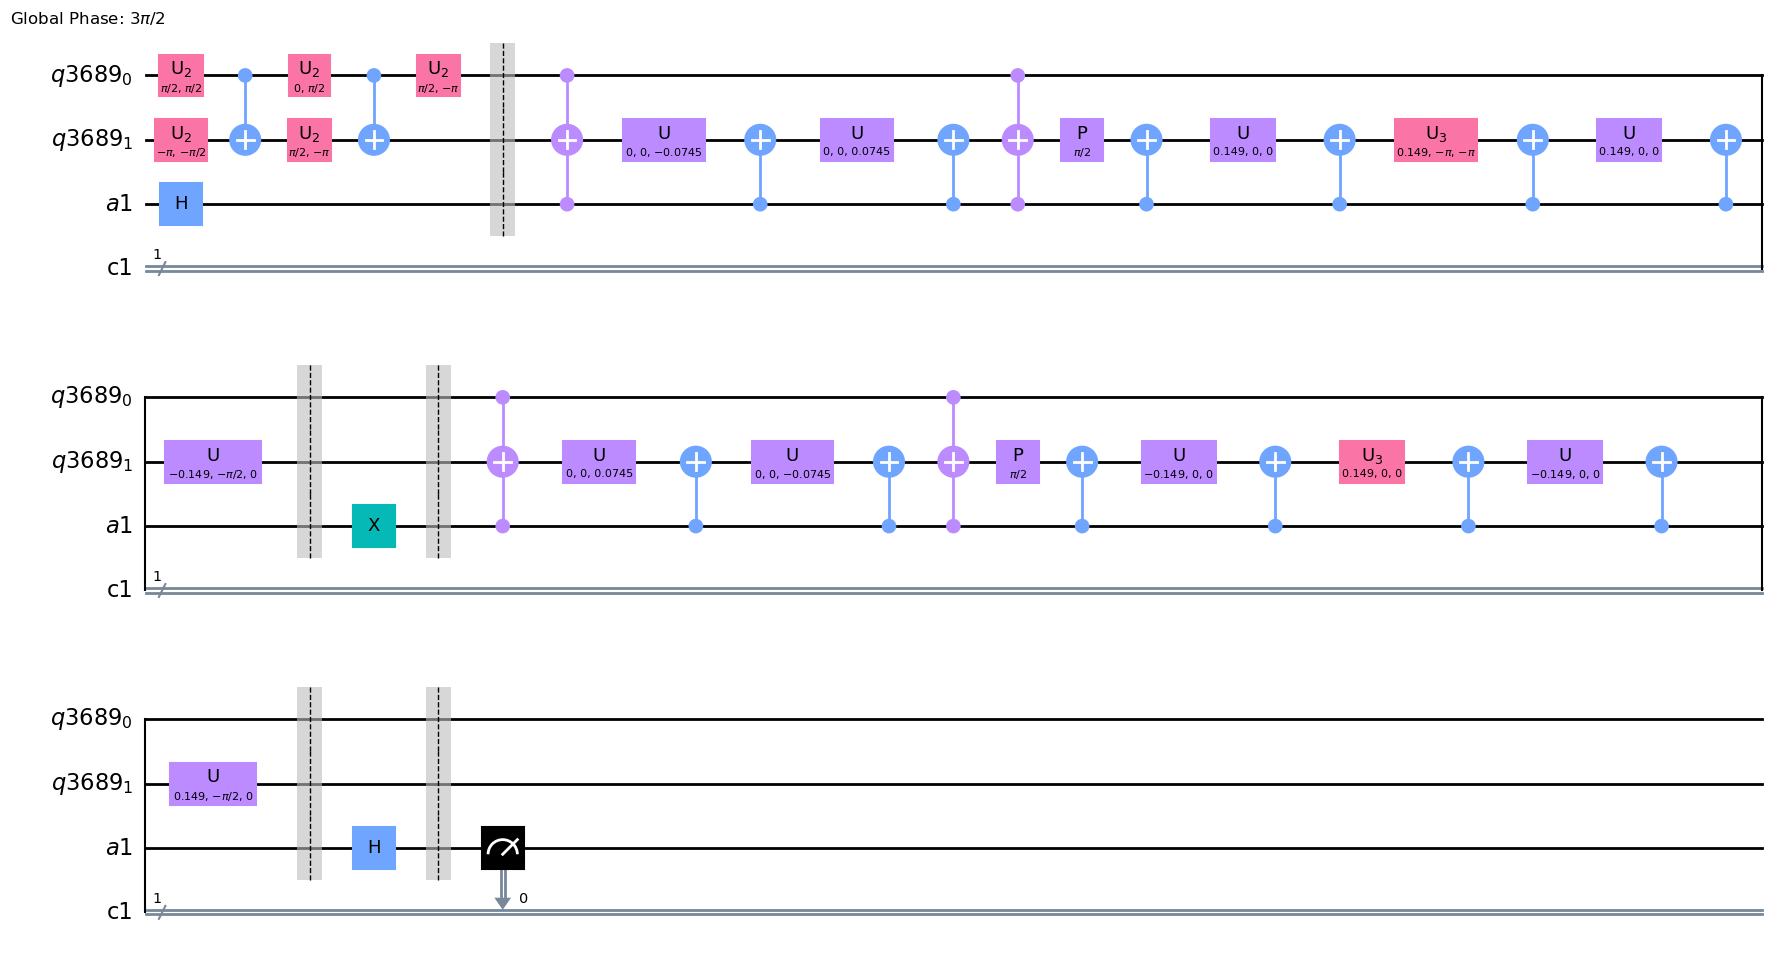

In [15]:
trot_tcs[0].draw('mpl')

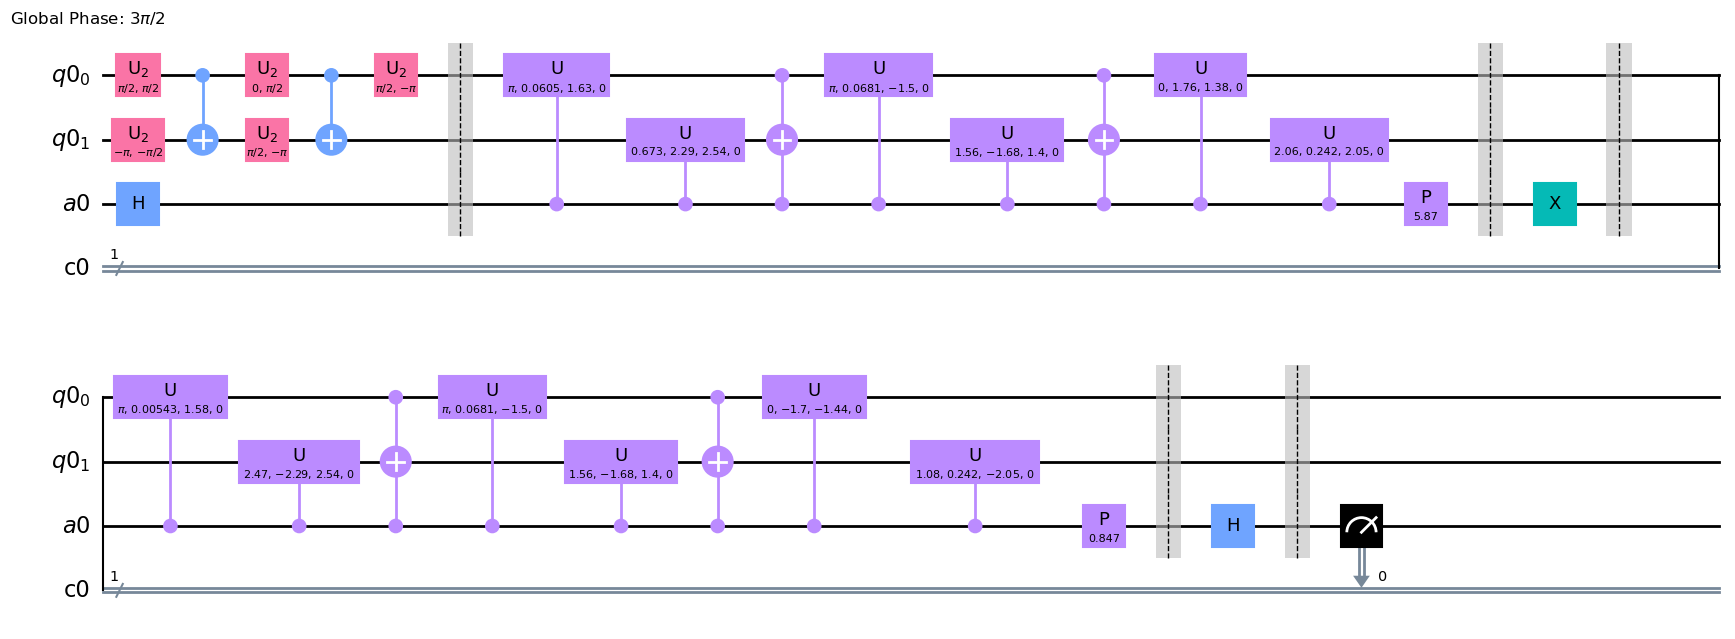

In [16]:
transpile(he_circs_re[0], backend)[-1].draw('mpl')